In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('combined_matchups.csv')



In [2]:
# Identify target/outcome variables (to exclude)
target_cols = ['WIN', 'UPSET', 'SCORE', 'SCORE_diff']  # Add others if needed
id_cols = ['Team_1', 'Team_2', 'game_id']  # Adjust based on your dataset
exclude_cols = target_cols + id_cols

# 1. Separate predictors
X = df.drop(columns=exclude_cols, errors='ignore')

# 2. Dummy encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# 3. Handle missing values if present
X_encoded = X_encoded.dropna()  # Or use imputation if you prefer

# Keep index for rejoining
original_index = X_encoded.index.copy()

# 4. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)


In [3]:
X_encoded

,YEAR,ROUND,SEED_1,SEED_2,K TEMPO_diff,KADJ T_diff,K OFF_diff,KADJ O_diff,K DEF_diff,KADJ D_diff,...,TEAM_2_Western Kentucky,TEAM_2_Western Michigan,TEAM_2_Wichita St.,TEAM_2_Winthrop,TEAM_2_Wisconsin,TEAM_2_Wofford,TEAM_2_Wright St.,TEAM_2_Wyoming,TEAM_2_Xavier,TEAM_2_Yale
70,2023,64,1.0,64.0,2.158,3.490,0.998,8.730,-10.348,-19.037,...,False,False,False,False,False,False,False,False,False,False
71,2023,64,32.0,33.0,-5.337,-4.243,0.056,-3.008,-3.929,-2.233,...,False,False,False,False,False,False,False,False,False,False
72,2023,64,17.0,48.0,-4.326,-4.948,-5.790,0.551,0.831,-7.943,...,False,False,False,False,False,False,False,False,False,False
73,2023,64,16.0,49.0,-6.445,-6.889,-7.131,-3.034,-6.193,-11.021,...,False,False,False,False,False,False,False,False,False,False
74,2023,64,24.0,41.0,-0.375,-1.152,-1.706,0.727,-3.588,-6.623,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,2016,8,3.0,22.0,5.311,6.142,1.178,1.449,-9.115,-10.608,...,False,False,False,False,False,False,False,False,False,False
506,2016,8,2.0,39.0,-4.072,-4.209,7.994,8.867,-2.471,-4.378,...,False,False,False,False,False,False,False,False,False,False
507,2016,4,8.0,5.0,-3.590,-3.310,2.319,1.014,-3.836,-0.884,...,False,False,False,False,False,False,False,False,False,False
508,2016,4,3.0,39.0,5.478,6.171,9.478,9.782,-1.045,-2.406,...,False,False,False,False,False,False,False,False,False,False


In [17]:
# Fit Isolation Forest
iso = IsolationForest(n_estimators=200, contamination=.05, random_state=25)
anomaly_preds = iso.fit_predict(X_scaled)

# Initialize with NaNs or 0s, then assign to filtered rows
df['anomaly_score'] = np.nan
df['is_anomaly'] = 0

# Assign results only to the rows used in X_encoded
df.loc[original_index, 'anomaly_score'] = anomaly_preds
df.loc[original_index, 'is_anomaly'] = (anomaly_preds == -1).astype(int)


0

In [18]:

# View some top anomalies with key info
anomalies = df[df['is_anomaly'] == 1]
anomalies

#print(anomalies[['Team_1', 'Team_2', 'ROUND', 'UPSET']].head())


,YEAR,ROUND,CONF_1,TEAM_1,SEED_1,SEED_2,CONF_2,TEAM_2,SCORE_diff,K TEMPO_diff,...,FARTHER TWOS SHARE_diff,FARTHER TWOS FG%D_diff,FARTHER TWOS D SHARE_diff,THREES FG%_diff,THREES SHARE_diff,THREES FG%D_diff,THREES D SHARE_diff,target,anomaly_score,is_anomaly
78,2023,64,B10,Purdue,4.0,61.0,NEC,Fairleigh Dickinson,-5.0,-5.054,...,3.1,-6.1,14.2,-2.1,0.7,-4.0,-4.6,0.0,-1.0,1
86,2023,64,Amer,Houston,3.0,62.0,Horz,Northern Kentucky,11.0,1.623,...,7.5,-10.9,-0.9,-0.3,-3.0,-8.5,4.8,1.0,-1.0,1
101,2023,64,P12,UCLA,7.0,58.0,BSth,UNC Asheville,33.0,-1.314,...,7.9,1.5,-1.1,-3.7,-8.3,0.5,5.0,1.0,-1.0,1
106,2023,32,NEC,Fairleigh Dickinson,61.0,36.0,CUSA,Florida Atlantic,-8.0,0.542,...,9.9,4.4,-9.7,-2.3,-6.2,2.9,5.4,0.0,-1.0,1
133,2022,64,WCC,Gonzaga,1.0,64.0,SB,Georgia St.,21.0,6.013,...,-10.3,-3.3,5.1,4.6,-1.0,-7.0,-4.2,1.0,-1.0,1
184,2022,16,B10,Purdue,12.0,60.0,MAAC,Saint Peter's,-3.0,-0.425,...,0.8,4.0,5.0,3.8,8.9,4.0,4.3,0.0,-1.0,1
196,2021,64,WCC,Gonzaga,1.0,64.0,MEAC,Norfolk St.,43.0,3.233,...,-11.4,1.2,12.0,-0.4,-2.4,1.0,-12.2,1.0,-1.0,1
246,2021,16,P12,UCLA,44.0,5.0,SEC,Alabama,10.0,-9.885,...,27.3,5.7,-3.0,2.0,-14.9,4.5,3.5,1.0,-1.0,1
254,2021,8,P12,Oregon St.,47.0,7.0,Amer,Houston,-6.0,-0.343,...,1.3,7.0,-2.7,0.3,-6.9,0.7,1.1,0.0,-1.0,1
258,2019,64,ACC,Duke,1.0,64.0,Sum,North Dakota St.,23.0,7.190,...,0.8,-12.5,0.8,-5.9,-10.7,-7.1,-0.5,1.0,-1.0,1


In [19]:
explainer = shap.Explainer(iso, X_scaled, feature_names=X_encoded.columns)
shap_values = explainer(X_scaled)

# Compute global feature importances
shap_sum = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': X_encoded.columns,
    'mean_abs_shap': shap_sum
}).sort_values('mean_abs_shap', ascending=False)

<Figure size 1000x600 with 0 Axes>

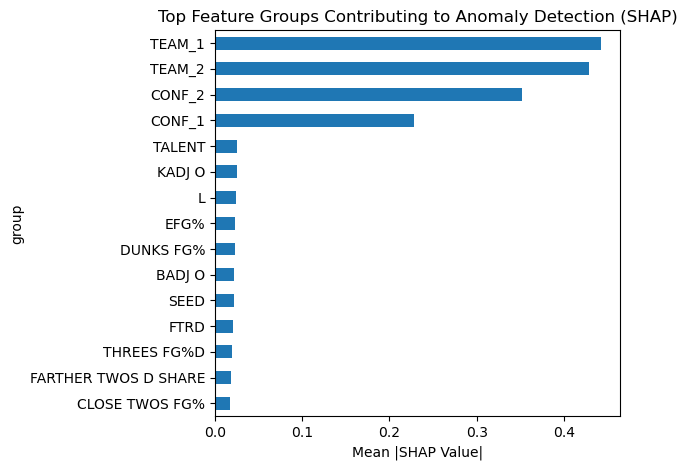

In [20]:
# Group features by original variable name (before dummy encoding)
def group_feature_names(feature_names):
    grouped_names = []
    for name in feature_names:
        if "_" in name:
            # Try splitting on last underscore (for safety)
            parts = name.rsplit("_", 1)
            base = parts[0]
            grouped_names.append(base)
        else:
            grouped_names.append(name)
    return grouped_names

# Apply to SHAP importances
importance_df['group'] = group_feature_names(importance_df['feature'])

# Aggregate SHAP values by group
grouped_shap = (importance_df
                .groupby('group')['mean_abs_shap']
                .sum()
                .sort_values(ascending=False)
                .reset_index())

# Visualize top feature groups
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
grouped_shap.head(15).plot(kind='barh', x='group', y='mean_abs_shap', legend=False)
plt.gca().invert_yaxis()
plt.title('Top Feature Groups Contributing to Anomaly Detection (SHAP)')
plt.xlabel('Mean |SHAP Value|')
plt.tight_layout()
plt.show()



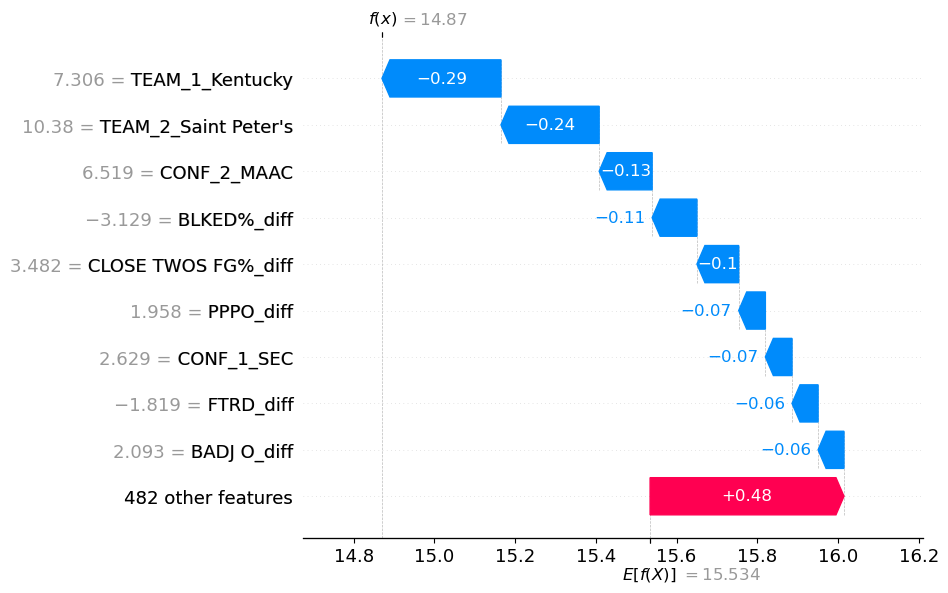

In [21]:
idx = df[df['is_anomaly'] == 1].index[0]
shap.plots.waterfall(shap_values[idx], max_display=10)


### Reinforcement Learning

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [ ]:

# Load matchup-level data
df = pd.read_csv("combined_matchups.csv")

# Create target based on SCORE_diff
df = df.dropna(subset=['SCORE_diff'])  # Ensure no missing score differences
df['action'] = (df['SCORE_diff'] > 0).astype(int)  # 1 if Team 1 won



# Normalize margin of victory (to keep reward range stable)
df['margin_reward'] = df['SCORE_diff'] / 50.0  # adjust denominator if needed

feature_cols = [col for col in df.columns if col.endswith('_diff') and df[col].dtype != 'object']
X = df[feature_cols].dropna()
y = (df.loc[X.index, 'SCORE_diff'] > 0).astype(int)
margins = df.loc[X.index, 'margin_reward']




In [40]:

feature_cols = [col for col in df.columns if col.endswith('_diff') and df[col].dtype != 'object']
X = df[feature_cols].dropna()
y = df.loc[X.index, 'action']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=25)


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim

class QAgent(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super(QAgent, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # 2 actions: predict win for Team 1 or Team 2
        )

    def forward(self, x):
        return self.model(x)

# Initialize model
agent = QAgent(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(agent.parameters(), lr=0.001)


/opt/anaconda3/envs/shared/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [44]:
train_accuracies = []
test_accuracies = []

X_train, X_test, y_train, y_test = train_test_split(
    df[feature_cols], df['action'], test_size=0.2, random_state=42)
margins_train = df.loc[X_train.index, 'margin_reward'].values

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_tensor = torch.FloatTensor(X_train_scaled)
y_tensor = torch.LongTensor(y_train.values)

for epoch in range(n_epochs):
    agent.train()
    total_loss = 0
    correct = 0

    for i in range(X_tensor.shape[0]):
        state = X_tensor[i].unsqueeze(0)
        true_action = y_tensor[i].item()
        margin = margins_train[i]

        # Predict Q-values
        q_values = agent(state)
        predicted_action = torch.argmax(q_values).item()
        correct += (predicted_action == true_action)

        # Use signed margin as reward
        reward = margin if predicted_action == true_action else -margin

        # Q-learning target
        target = q_values.clone().detach()
        target[0, true_action] = reward

        loss = criterion(q_values, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Accuracy
    train_acc = correct / len(X_train)
    train_accuracies.append(train_acc)

    agent.eval()
    with torch.no_grad():
        test_preds = torch.argmax(agent(torch.FloatTensor(X_test_scaled)), dim=1).numpy()
        test_acc = (test_preds == y_test.values).mean()
        test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%} | Loss: {total_loss:.4f}")


Epoch 1 | Train Acc: 43.94% | Test Acc: 40.45% | Loss: nan
Epoch 2 | Train Acc: 43.94% | Test Acc: 40.45% | Loss: nan
Epoch 3 | Train Acc: 43.94% | Test Acc: 40.45% | Loss: nan
Epoch 4 | Train Acc: 43.94% | Test Acc: 40.45% | Loss: nan
Epoch 5 | Train Acc: 43.94% | Test Acc: 40.45% | Loss: nan
Epoch 6 | Train Acc: 43.94% | Test Acc: 40.45% | Loss: nan
Epoch 7 | Train Acc: 43.94% | Test Acc: 40.45% | Loss: nan
Epoch 8 | Train Acc: 43.94% | Test Acc: 40.45% | Loss: nan
Epoch 9 | Train Acc: 43.94% | Test Acc: 40.45% | Loss: nan
Epoch 10 | Train Acc: 43.94% | Test Acc: 40.45% | Loss: nan
Epoch 11 | Train Acc: 43.94% | Test Acc: 40.45% | Loss: nan
Epoch 12 | Train Acc: 43.94% | Test Acc: 40.45% | Loss: nan
Epoch 13 | Train Acc: 43.94% | Test Acc: 40.45% | Loss: nan
Epoch 14 | Train Acc: 43.94% | Test Acc: 40.45% | Loss: nan
Epoch 15 | Train Acc: 43.94% | Test Acc: 40.45% | Loss: nan
Epoch 16 | Train Acc: 43.94% | Test Acc: 40.45% | Loss: nan
Epoch 17 | Train Acc: 43.94% | Test Acc: 40.45% |

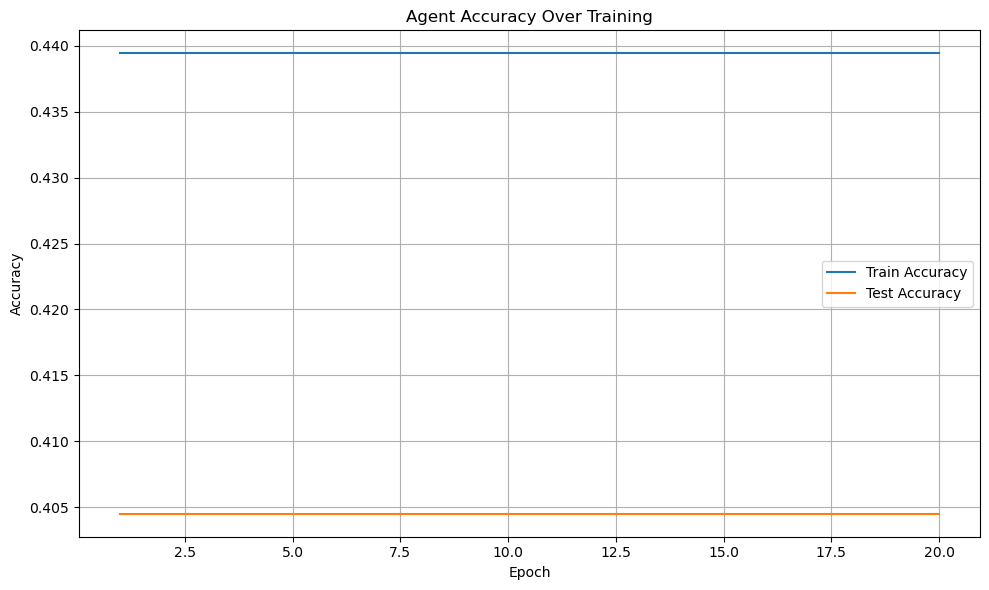

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(range(1, n_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, n_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Agent Accuracy Over Training')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def simulate_bracket(df, agent, year=2024):
    # Subset bracket
    bracket = df[df['Year'] == year].copy()
    round_nums = sorted(bracket['ROUND'].unique())

    current_round = 64
    advancing_teams = set()

    print(f"\n🏀 Simulating Bracket for {year} Tournament:\n")

    for rnd in round_nums:
        matchups = bracket[bracket['ROUND'] == rnd]
        print(f"🔹 Round of {current_round}: {len(matchups)} games")

        winners = []
        for _, row in matchups.iterrows():
            features = row[feature_cols].values.astype(float)
            features_scaled = scaler.transform([features])
            q_vals = agent(torch.FloatTensor(features_scaled))
            pred = torch.argmax(q_vals).item()

            winner = row['Team_1'] if pred == 1 else row['Team_2']
            winners.append(winner)

            print(f"{row['Team_1']} vs {row['Team_2']} ➝ {winner}")

        advancing_teams = winners
        current_round //= 2

    print(f"\n🏆 Champion Prediction: {advancing_teams[0]}")


In [ ]:
simulate_bracket(df, agent, year=2024)


In [48]:
df['margin_reward'] = df['SCORE_diff'] / 50.0  # adjust denominator if needed

feature_cols = [col for col in df.columns if col.endswith('_diff') and df[col].dtype != 'object']
X = df[feature_cols].dropna()
y = (df.loc[X.index, 'SCORE_diff'] > 0).astype(int)
margins = df.loc[X.index, 'margin_reward']

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Define upgraded Q-network
class QAgent(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(QAgent, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate model
agent = QAgent(input_dim=X_train.shape[1])
criterion = nn.SmoothL1Loss()  # Robust loss
optimizer = optim.Adam(agent.parameters(), lr=0.0001)  # Slower LR for stability

# Dataset & DataLoader
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
margins_train = df.loc[X_train.index, 'margin_reward'].values

train_dataset = TensorDataset(
    torch.FloatTensor(X_train_scaled),
    torch.FloatTensor(margins_train),
    torch.LongTensor(y_train.values)
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Tracking metrics
train_accuracies = []
test_accuracies = []
epoch_rewards = []

n_epochs = 20
epsilon = 0.1  # Exploration rate

for epoch in range(n_epochs):
    agent.train()
    total_reward = 0
    total_correct = 0
    total_samples = 0

    for X_batch, margin_batch, y_batch in train_loader:
        q_vals = agent(X_batch)

        # ε-greedy predictions
        random_actions = torch.randint(0, 2, y_batch.shape)
        max_actions = torch.argmax(q_vals, dim=1)
        take_random = torch.rand(y_batch.shape) < epsilon
        predictions = torch.where(take_random, random_actions, max_actions)

        rewards = torch.where(predictions == y_batch, margin_batch, -margin_batch)
        total_reward += rewards.sum().item()
        total_correct += (predictions == y_batch).sum().item()
        total_samples += y_batch.size(0)

        # Q-learning target
        target = q_vals.clone().detach()
        for i in range(len(y_batch)):
            target[i, y_batch[i]] = rewards[i]

        loss = criterion(q_vals, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Train accuracy and reward
    train_acc = total_correct / total_samples
    avg_reward = total_reward / total_samples
    train_accuracies.append(train_acc)
    epoch_rewards.append(avg_reward)

    # Test accuracy
    agent.eval()
    with torch.no_grad():
        test_preds = torch.argmax(agent(torch.FloatTensor(X_test_scaled)), dim=1).numpy()
        test_acc = (test_preds == y_test.values).mean()
        test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1:2d} | Train Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%} | Avg Reward: {avg_reward:.4f}")


Epoch  1 | Train Acc: 45.07% | Test Acc: 40.45% | Avg Reward: nan
Epoch  2 | Train Acc: 44.37% | Test Acc: 40.45% | Avg Reward: nan
Epoch  3 | Train Acc: 46.06% | Test Acc: 40.45% | Avg Reward: nan
Epoch  4 | Train Acc: 44.79% | Test Acc: 40.45% | Avg Reward: nan
Epoch  5 | Train Acc: 44.08% | Test Acc: 40.45% | Avg Reward: nan
Epoch  6 | Train Acc: 43.66% | Test Acc: 40.45% | Avg Reward: nan
Epoch  7 | Train Acc: 45.21% | Test Acc: 40.45% | Avg Reward: nan
Epoch  8 | Train Acc: 44.08% | Test Acc: 40.45% | Avg Reward: nan
Epoch  9 | Train Acc: 44.23% | Test Acc: 40.45% | Avg Reward: nan
Epoch 10 | Train Acc: 43.66% | Test Acc: 40.45% | Avg Reward: nan
Epoch 11 | Train Acc: 45.49% | Test Acc: 40.45% | Avg Reward: nan
Epoch 12 | Train Acc: 44.93% | Test Acc: 40.45% | Avg Reward: nan
Epoch 13 | Train Acc: 45.35% | Test Acc: 40.45% | Avg Reward: nan
Epoch 14 | Train Acc: 44.79% | Test Acc: 40.45% | Avg Reward: nan
Epoch 15 | Train Acc: 44.23% | Test Acc: 40.45% | Avg Reward: nan
Epoch 16 |

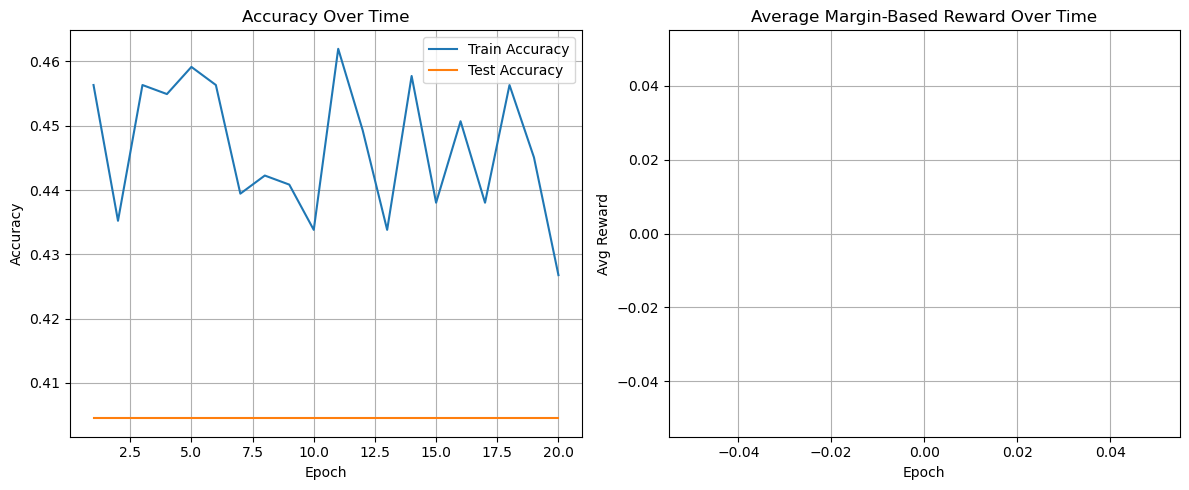

In [47]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, n_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs+1), epoch_rewards, color='purple')
plt.xlabel('Epoch')
plt.ylabel('Avg Reward')
plt.title('Average Margin-Based Reward Over Time')
plt.grid(True)

plt.tight_layout()
plt.show()
